# Upload dataset

In [1]:
! pip install -q kaggle



In [2]:
""" from google.colab import files
 files.upload()"""

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"metlnfoor","key":"14f026d097f6ecd242987990ac003d76"}'}

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/



In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json



In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -qq brain-tumor-mri-dataset.zip


replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Libraries

In [8]:
import cv2
import os
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision


# Files

In [9]:
glioma_path = "/content/Training/glioma"
meningioma_path = "/content/Training/meningioma"
notumor_path = "/content/Training/notumor"
pituitary_path = "/content/Training/pituitary"

glioma_list = os.listdir(glioma_path)
meningioma_list = os.listdir(meningioma_path)
notumor_list = os.listdir(notumor_path)
pituitary_list = os.listdir(pituitary_path)



# Plotting

In [10]:
def plot_images_in_folder(folder_path, num_images=4, figsize=(20, 5)):

    file_list = os.listdir(folder_path)
    fig, axs = plt.subplots(1, num_images, figsize=figsize)
    for i, file_name in enumerate(file_list[:num_images]):
        img = cv2.imread(os.path.join(folder_path, file_name))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axs[i].imshow(img_rgb)
        axs[i].set_title(file_name)
        axs[i].axis('off')

    plt.show()

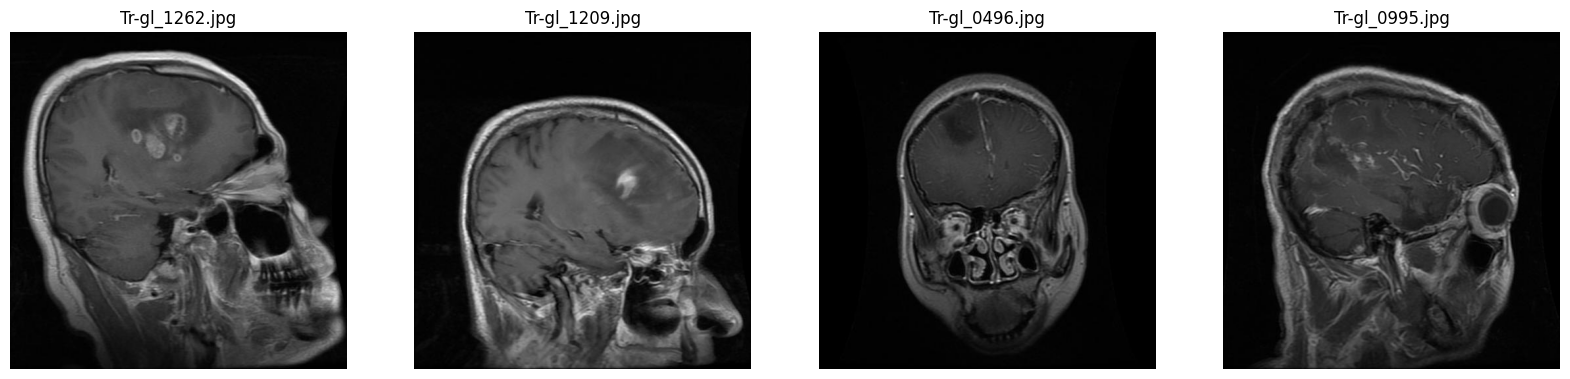

In [11]:
plot_images_in_folder(glioma_path)

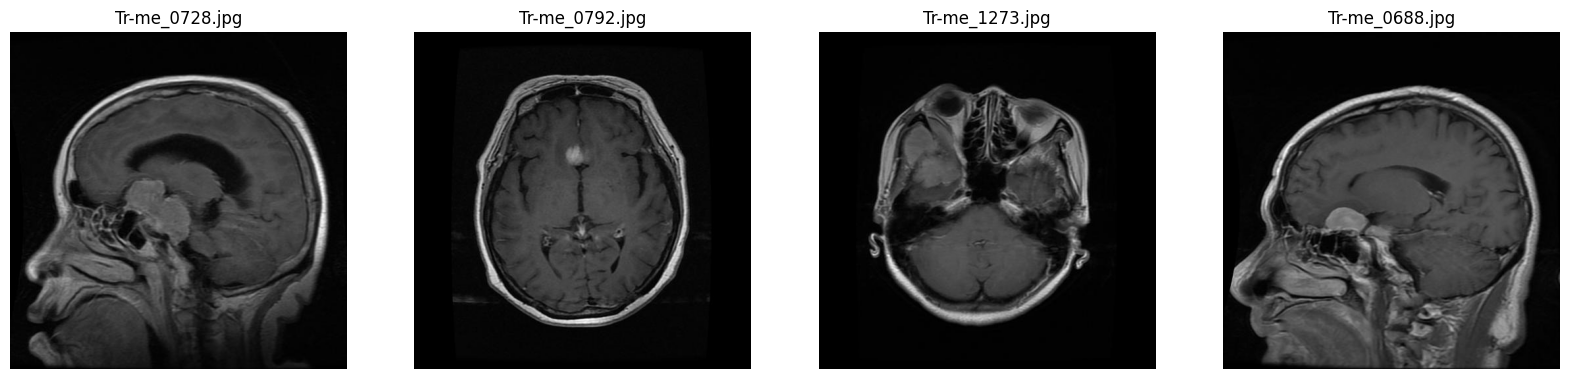

In [12]:
plot_images_in_folder(meningioma_path)

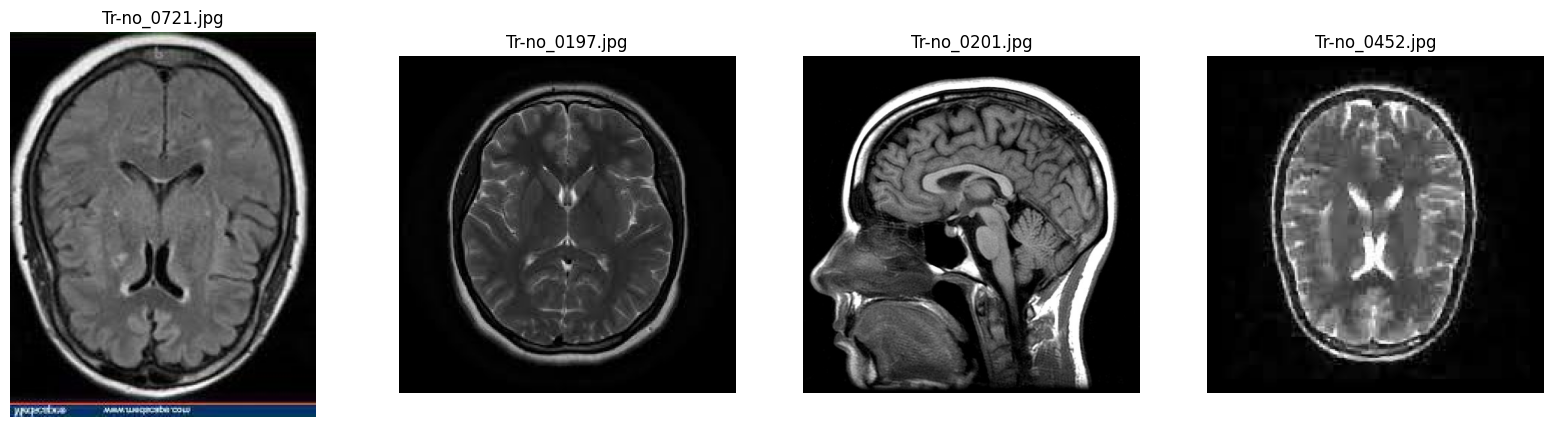

In [13]:
plot_images_in_folder(notumor_path)

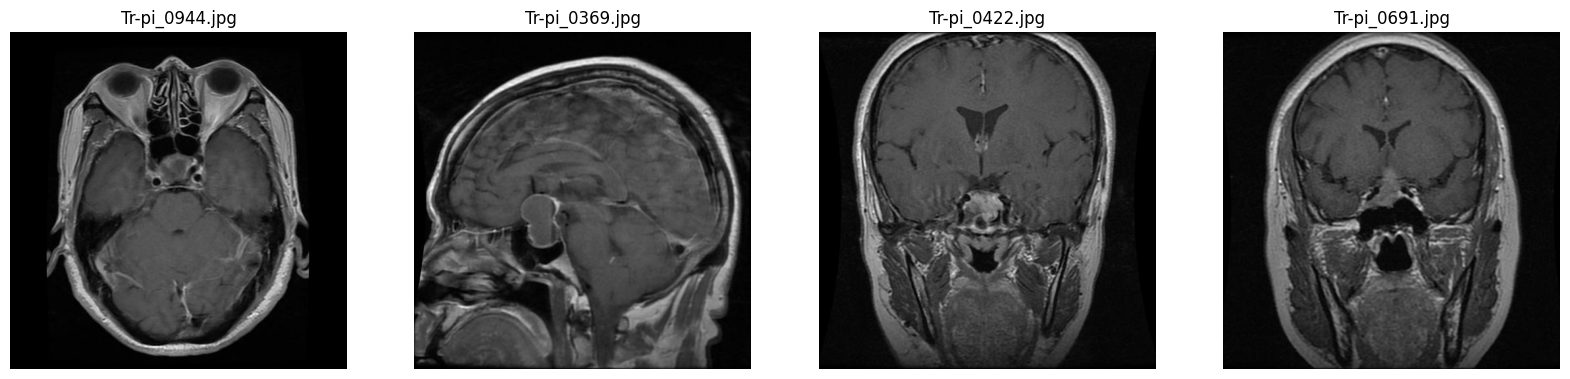

In [14]:
plot_images_in_folder(pituitary_path)

In [15]:
IMAGE_SIZE = 224 # We need to resize the images given resnet takes input of image size >= 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

learning_rate = 0.01
random_seed = 5361
num_epochs = 20
batch_size = 128



# These values are mostly used by researchers as found to very useful in fast convergence

composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std),]) # Normalizing with standard mean and standard deviation


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

train_dataset = ImageFolder(root="/content/Training", transform=composed_train)
test_dataset = ImageFolder(root="/content/Testing", transform=composed_test)

# Veri yükleyicileri oluşturma
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes =  len(train_dataset.classes)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL

In [17]:
# Resnet Block
# --------------------Conv--> Batch Norm--------------------------------------->---
# |                                                                               |
# |               Residual Block 1                                                |
# X ---->Conv1 ---->BatchNorm1 ---->ReLu1--------------->Conv2---->BatchMorm2-----> (+)-----> ReLu --->

In [50]:
#Residual Block
class ResidualBlock(torch.nn.Module):

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
                #Conv 1
                nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[1],
                                kernel_size=(3, 3),
                                stride=(2, 2),
                                padding=1),

                #BatchNorm 1
                nn.BatchNorm2d(channels[1]),
                #Relu 1
                nn.ReLU(inplace=True),

                #Conv 2
                nn.Conv2d(in_channels=channels[1],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                # BatchNorm 2
                nn.BatchNorm2d(channels[2])
        )

        self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(2, 2),
                                padding=0),
                nn.BatchNorm2d(channels[2])
        )

    def forward(self, x):
        shortcut = x

        block = self.block(x)
        shortcut = self.shortcut(x)
        x = nn.functional.relu(block+shortcut)

        return x

In [51]:
class ResNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        self.residual_block_1 = ResidualBlock(channels=[3, 8, 16])
        self.residual_block_2 = ResidualBlock(channels=[16, 64, 128])

        self.linear_1 = torch.nn.Linear(128* 56* 56, num_classes)


    def forward(self, x):

        out = self.residual_block_1(x)
        out = self.residual_block_2(out)
        out = out.view(out.size(0), -1)

        logits = self.linear_1(out)
        return logits


In [52]:
torch.manual_seed(random_seed)
model = ResNet(num_classes=num_classes)

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [53]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


In [55]:
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits = model(features)
        cost =criterion(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_dataset)//batch_size, cost))

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs,
              compute_accuracy(model, train_loader)))

Epoch: 001/020 | Batch 000/044 | Cost: 84.3838
Epoch: 001/020 training accuracy: 76.56%
Epoch: 002/020 | Batch 000/044 | Cost: 10.0484
Epoch: 002/020 training accuracy: 79.99%
Epoch: 003/020 | Batch 000/044 | Cost: 4.5412
Epoch: 003/020 training accuracy: 83.96%
Epoch: 004/020 | Batch 000/044 | Cost: 1.5361
Epoch: 004/020 training accuracy: 84.68%
Epoch: 005/020 | Batch 000/044 | Cost: 1.5304
Epoch: 005/020 training accuracy: 88.43%
Epoch: 006/020 | Batch 000/044 | Cost: 1.7717
Epoch: 006/020 training accuracy: 87.15%
Epoch: 007/020 | Batch 000/044 | Cost: 1.9777
Epoch: 007/020 training accuracy: 91.68%
Epoch: 008/020 | Batch 000/044 | Cost: 0.7701
Epoch: 008/020 training accuracy: 91.70%
Epoch: 009/020 | Batch 000/044 | Cost: 0.4057
Epoch: 009/020 training accuracy: 91.86%
Epoch: 010/020 | Batch 000/044 | Cost: 0.3278
Epoch: 010/020 training accuracy: 90.79%
Epoch: 011/020 | Batch 000/044 | Cost: 0.4013
Epoch: 011/020 training accuracy: 92.31%
Epoch: 012/020 | Batch 000/044 | Cost: 0.

In [57]:
torch.save(model,"model_brain_resnet_scratch.pth")